In [1]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import requests

In [2]:
# Parameters for API request
drug_names = ["Kadcyla", "Adcetris", "Polivy", "Enhertu", "Trodelvy"]  # List of ADC drugs
#drug_names = ["Kadcyla"]  # List of ADC drugs
adv_event_filter = ['Febrile neutropenia', 'Diarrhoea', 'Myelosuppression', 'Myalgia']

In [3]:
total_records = 10000
batch_size    = 1000

In [4]:
url = "https://api.fda.gov/drug/event.json"

In [5]:
all_records = []
for drug_name in drug_names:
    for skip in tqdm(range(0, total_records, batch_size), desc = f"Processing ... \t\t\t {drug_name} \t\t "):
        params = {"search": f"patient.drug.medicinalproduct:{drug_name}", "limit": batch_size, "skip": skip}
        response = requests.get(url, params=params)
        
        if response.status_code != 200:
            continue  # Skip if there's a problem

        data = response.json()
        for result in data.get("results", []):
            seriousness = {
                "Death":            int(result.get("seriousnessdeath",           0)),
                "Hospitalization":  int(result.get("seriousnesshospitalization", 0)),
                "LifeThreatening":  int(result.get("seriousnesslifethreatening", 0)),
                "Disabling":        int(result.get("seriousnessdisabling",       0)),
                "Other":            int(result.get("seriousnessother",           0))
            }
            
            for reaction in result.get("patient", {}).get("reaction", []):
                record = {"ADC Name": drug_name, "Adverse Event": reaction.get("reactionmeddrapt", "Unknown"), **seriousness}
                all_records.append(record)

Processing ... 			 Kadcyla 		 :   0%|          | 0/10 [00:00<?, ?it/s]

Processing ... 			 Adcetris 		 :   0%|          | 0/10 [00:00<?, ?it/s]

Processing ... 			 Polivy 		 :   0%|          | 0/10 [00:00<?, ?it/s]

Processing ... 			 Enhertu 		 :   0%|          | 0/10 [00:00<?, ?it/s]

Processing ... 			 Trodelvy 		 :   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
# Convert to DataFrame
df = pd.DataFrame(all_records)
print(len(df)); df.sample(3)

68515


,ADC Name,Adverse Event,Death,Hospitalization,LifeThreatening,Disabling,Other
26621,Adcetris,Hepatic function abnormal,1,0,0,0,1
11458,Kadcyla,Hepatic enzyme increased,0,0,0,0,1
62473,Enhertu,Gastrointestinal infection,2,2,2,2,1


In [7]:
# Aggregate total counts for each seriousness flag by Adverse Event and ADC Name
agg = df.groupby(["ADC Name", "Adverse Event"]).sum(numeric_only=True)

# Compute the 'Total' column across all seriousness flags for each Adverse Event and ADC
agg["Total"] = agg.sum(axis=1)

# Reset index to flatten the DataFrame (remove multi-level index)
agg_reset = agg.reset_index()
agg_reset = agg_reset.sort_values(by='Total', ascending=False)
print(len(agg));agg_reset.head(5)

7123


,ADC Name,Adverse Event,Death,Hospitalization,LifeThreatening,Disabling,Other,Total
2835,Enhertu,Nausea,1338,1243,1457,1455,1258,6751
2664,Enhertu,Interstitial lung disease,1121,1070,1284,1329,1062,5866
5717,Polivy,Disease progression,1133,1274,1291,1232,817,5747
2901,Enhertu,Off label use,945,963,1033,1041,916,4898
2269,Enhertu,Disease progression,804,922,1089,1101,921,4837


In [8]:
# Normalizes the Death, Hospitalization, and LifeThreatening columns within each drug (ADC Name), ensuring their values sum to 100%. It groups the data by drug, 
# calculates the total for each seriousness column, and then divides each value by its respective total, multiplying by 100 to get percentages.
# It then drops the temporary total column and fills any NaN values.

# Step 1: Group by 'ADC Name' and sum each seriousness column
agg_reset['Total Seriousness'] = agg_reset.groupby('ADC Name')[['Death', 'Hospitalization', 'LifeThreatening']].transform('sum').sum(axis=1)

# Step 2: Normalize each column by dividing by the sum of that column for each drug
for col in ['Death', 'Hospitalization', 'LifeThreatening']:
    agg_reset[col] = agg_reset[col] * 100 / agg_reset.groupby('ADC Name')[col].transform('sum')

# Step 3: Drop the temporary 'Total Seriousness' column
agg_reset = agg_reset.drop(columns=['Total Seriousness'])

# Fill NaN values (if any)
agg_reset = agg_reset.fillna(0)
print(len(agg));agg_reset.head(5)

7123


,ADC Name,Adverse Event,Death,Hospitalization,LifeThreatening,Disabling,Other,Total
2835,Enhertu,Nausea,5.33,5.19,5.17,1455,1258,6751
2664,Enhertu,Interstitial lung disease,4.46,4.47,4.55,1329,1062,5866
5717,Polivy,Disease progression,11.60,10.76,10.51,1232,817,5747
2901,Enhertu,Off label use,3.76,4.02,3.66,1041,916,4898
2269,Enhertu,Disease progression,3.20,3.85,3.86,1101,921,4837


In [9]:
# Filter the data based on the adverse events list
agg_reset = agg_reset[agg_reset['Adverse Event'].isin(adv_event_filter)]
agg_reset.head(5)

,ADC Name,Adverse Event,Death,Hospitalization,LifeThreatening,Disabling,Other,Total
2261,Enhertu,Diarrhoea,2.25,2.08,2.16,615,518,2804
6570,Trodelvy,Diarrhoea,5.26,4.75,5.11,371,243,1635
680,Adcetris,Febrile neutropenia,2.39,2.29,2.34,302,275,1487
3915,Kadcyla,Diarrhoea,1.56,1.29,1.51,282,310,1398
4681,Kadcyla,Myelosuppression,1.07,0.84,1.08,192,148,891


In [10]:
df2 = agg_reset.head(25)

In [11]:
# Pivot data to create a matrix where seriousness flags are columns
#heatmap_data = agg_reset.pivot_table(index=["ADC Name", "Adverse Event"], values=["Death", "Hospitalization", "LifeThreatening", "Disabling", "Other"], aggfunc="sum")
heatmap_data = df2.pivot_table(index=["Adverse Event"], columns=["ADC Name"], values=["Death", "Hospitalization", "LifeThreatening", "Disabling", "Other"], aggfunc="sum")
heatmap_data = heatmap_data.fillna(0)

In [12]:
heatmap_data.head(5)

Death                                 Disabling  \
ADC Name            Adcetris Enhertu Kadcyla Polivy Trodelvy  Adcetris   
Adverse Event                                                            
Diarrhoea               1.03    2.25    1.56   0.99     5.26       120   
Febrile neutropenia     2.39    0.51    0.25   1.03     1.08       302   
Myalgia                 0.12    0.12    0.58   0.08     0.10        11   
Myelosuppression        1.11    0.62    1.07   0.80     1.00       155   

                                                     ... LifeThreatening  \
ADC Name            Enhertu Kadcyla Polivy Trodelvy  ...        Adcetris   
Adverse Event                                        ...                   
Diarrhoea               615     282    110      371  ...            1.01   
Febrile neutropenia     158      48     94       88  ...            2.34   
Myalgia                  30     104      8        8  ...            0.11   
Myelosuppression        162     192     78       66  ...            1.15   

                                                       Other                  \
ADC Name            Enhertu Kadcyla Polivy Trodelvy Adcetris Enhertu Kadcyla   
Adverse Event                                                                  
Diarrhoea              2.16    1.51   0.99     5.11      136     518     310   
Febrile neutropenia    0.52    0.23   1.02     1.17      275      95      81   
Myalgia                0.11    0.56   0.08     0.11       25      24     126   
Myelosuppression       0.57    1.08   0.84     0.87      103      92     148   

                                     
ADC Name            Polivy Trodelvy  
Adverse Event                        
Diarrhoea               83      243  
Febrile neutropenia     87       52  
Myalgia                  7        4  
Myelosuppression        81       35  

[4 rows x 25 columns]

In [13]:
# Normalize data using Z-score standardization
scaler = StandardScaler()
normalized_data = scaler.fit_transform(heatmap_data)

In [14]:
df_norm_row = heatmap_data.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
df_norm_row = df_norm_row.fillna(0)

<Figure size 1800x1800 with 0 Axes>

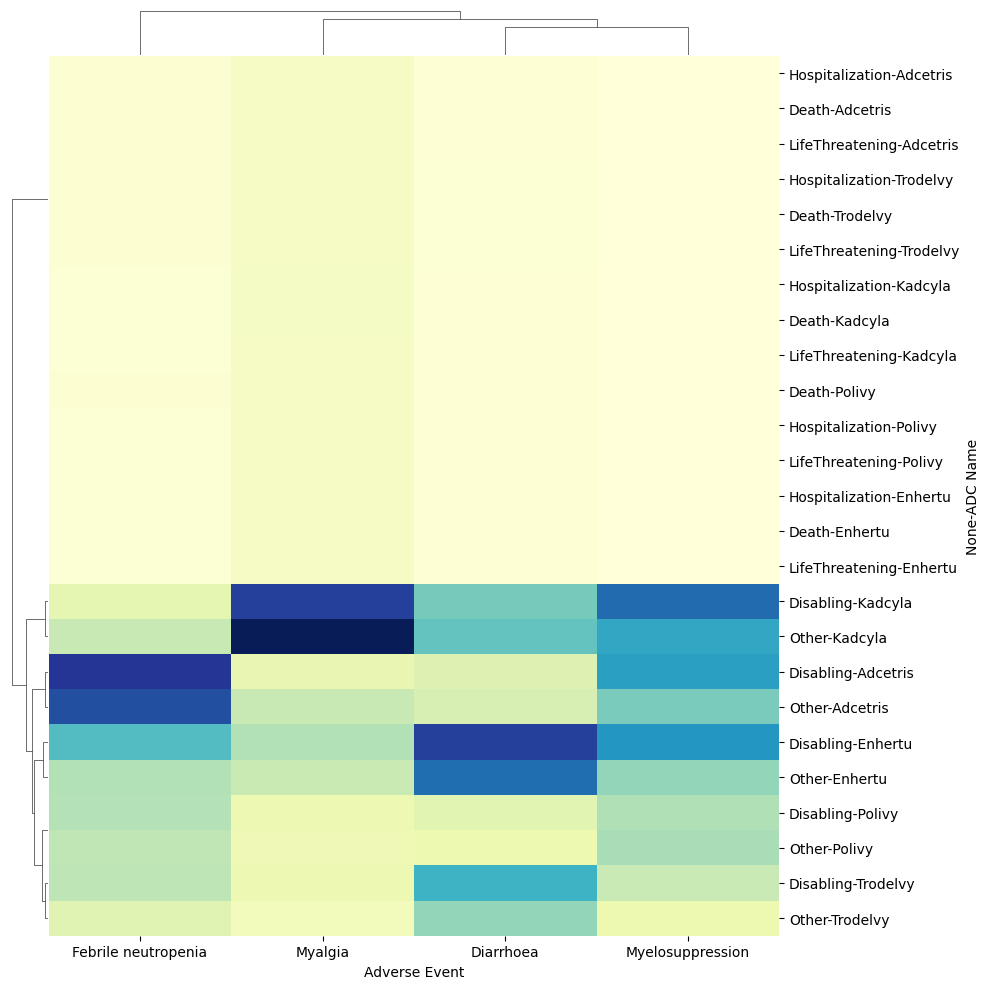

In [15]:
# Swap rows and columns in your heatmap data to flip the dendrogram axes
flipped_data = df_norm_row .T  # Transpose the data

# Create the clustermap with flipped dendrogram axes
plt.figure(figsize=(18, 18))
sns.clustermap(flipped_data, row_cluster=True, col_cluster=True, cmap="YlGnBu", method="ward", dendrogram_ratio=(0.05, 0.05), cbar_pos=None)

#plt.title("Scaled Heatmap with Hierarchical Clustering (Flipped Axes)")
plt.show()

<Figure size 1600x600 with 0 Axes>

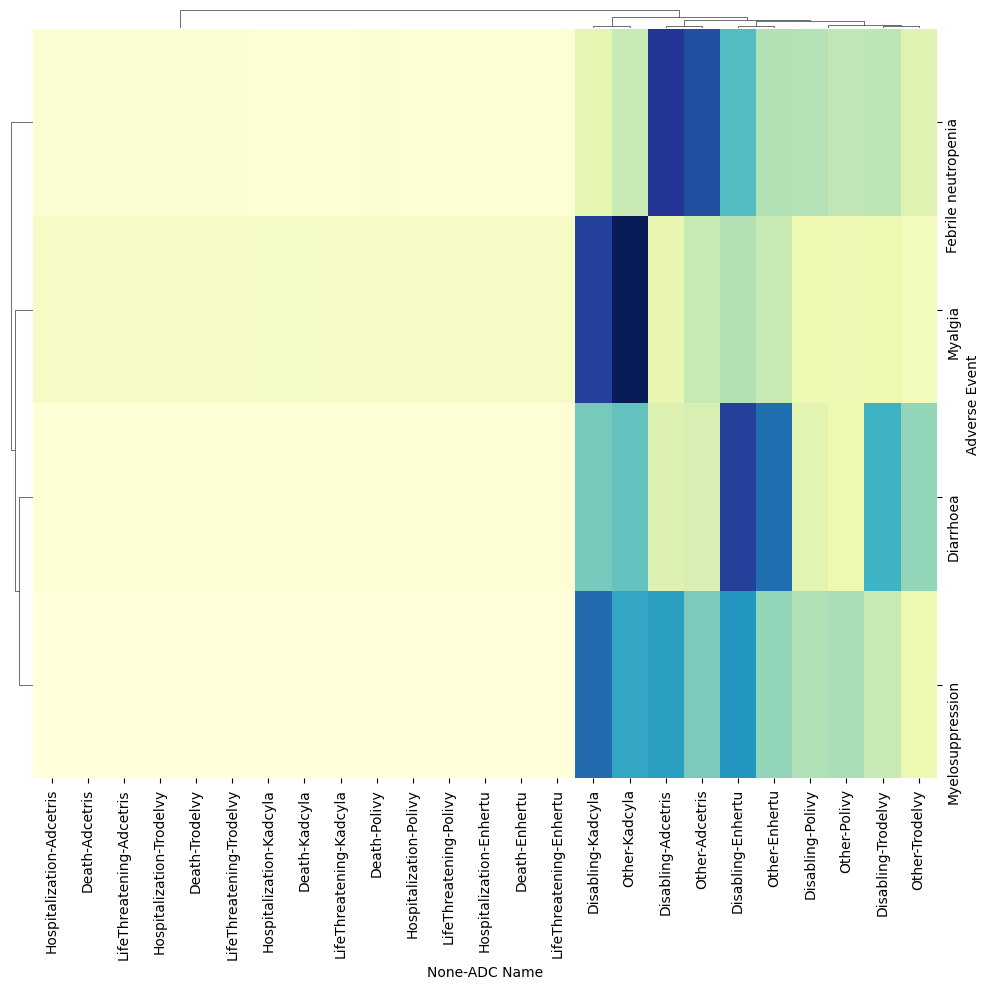

In [16]:
plt.figure(figsize=(16, 6))
sns.clustermap(df_norm_row , row_cluster=True, col_cluster=True, cmap="YlGnBu", method="ward", dendrogram_ratio=(0.025, 0.025), cbar_pos=None)
plt.show()